# Welcome to my Boxing Hit Detection Project!
By: Owen Levinthal\
(650) 722-7460\
levinthalowen@gmail.com\
https://www.linkedin.com/in/owenlev \
https://github.com/owen-levinthal



## Skills and Tools Used:
Python\
Extract, Transform, Load (ETL) Methods\
Data Cleaning/Visualization\
Exploratory Data Analysis (EDA)\
Time Series Aanlysis\
Algorithm Design\
Machine Learning Model Design/Training/Evaluation





## Background:
During my college years, I developed a deep passion for amateur boxing. Unlike the sensationalized spectacle of professional prize fighting seen on television, amateur boxing is friendly, relatively safe, and one of the greatest hobbies I've had the fortune of picking up. It not only challenged me physically but also enhanced my mental strength in ways that continue to benefit me. I strongly believe that the benefits of boxing can be extended to a broader audience, and my unique experience in the ring has equipped me with the ability to merge the worlds of boxing and data science in a way that can significantly impact the adoption of boxing, especially among those who are concerned about injuries.

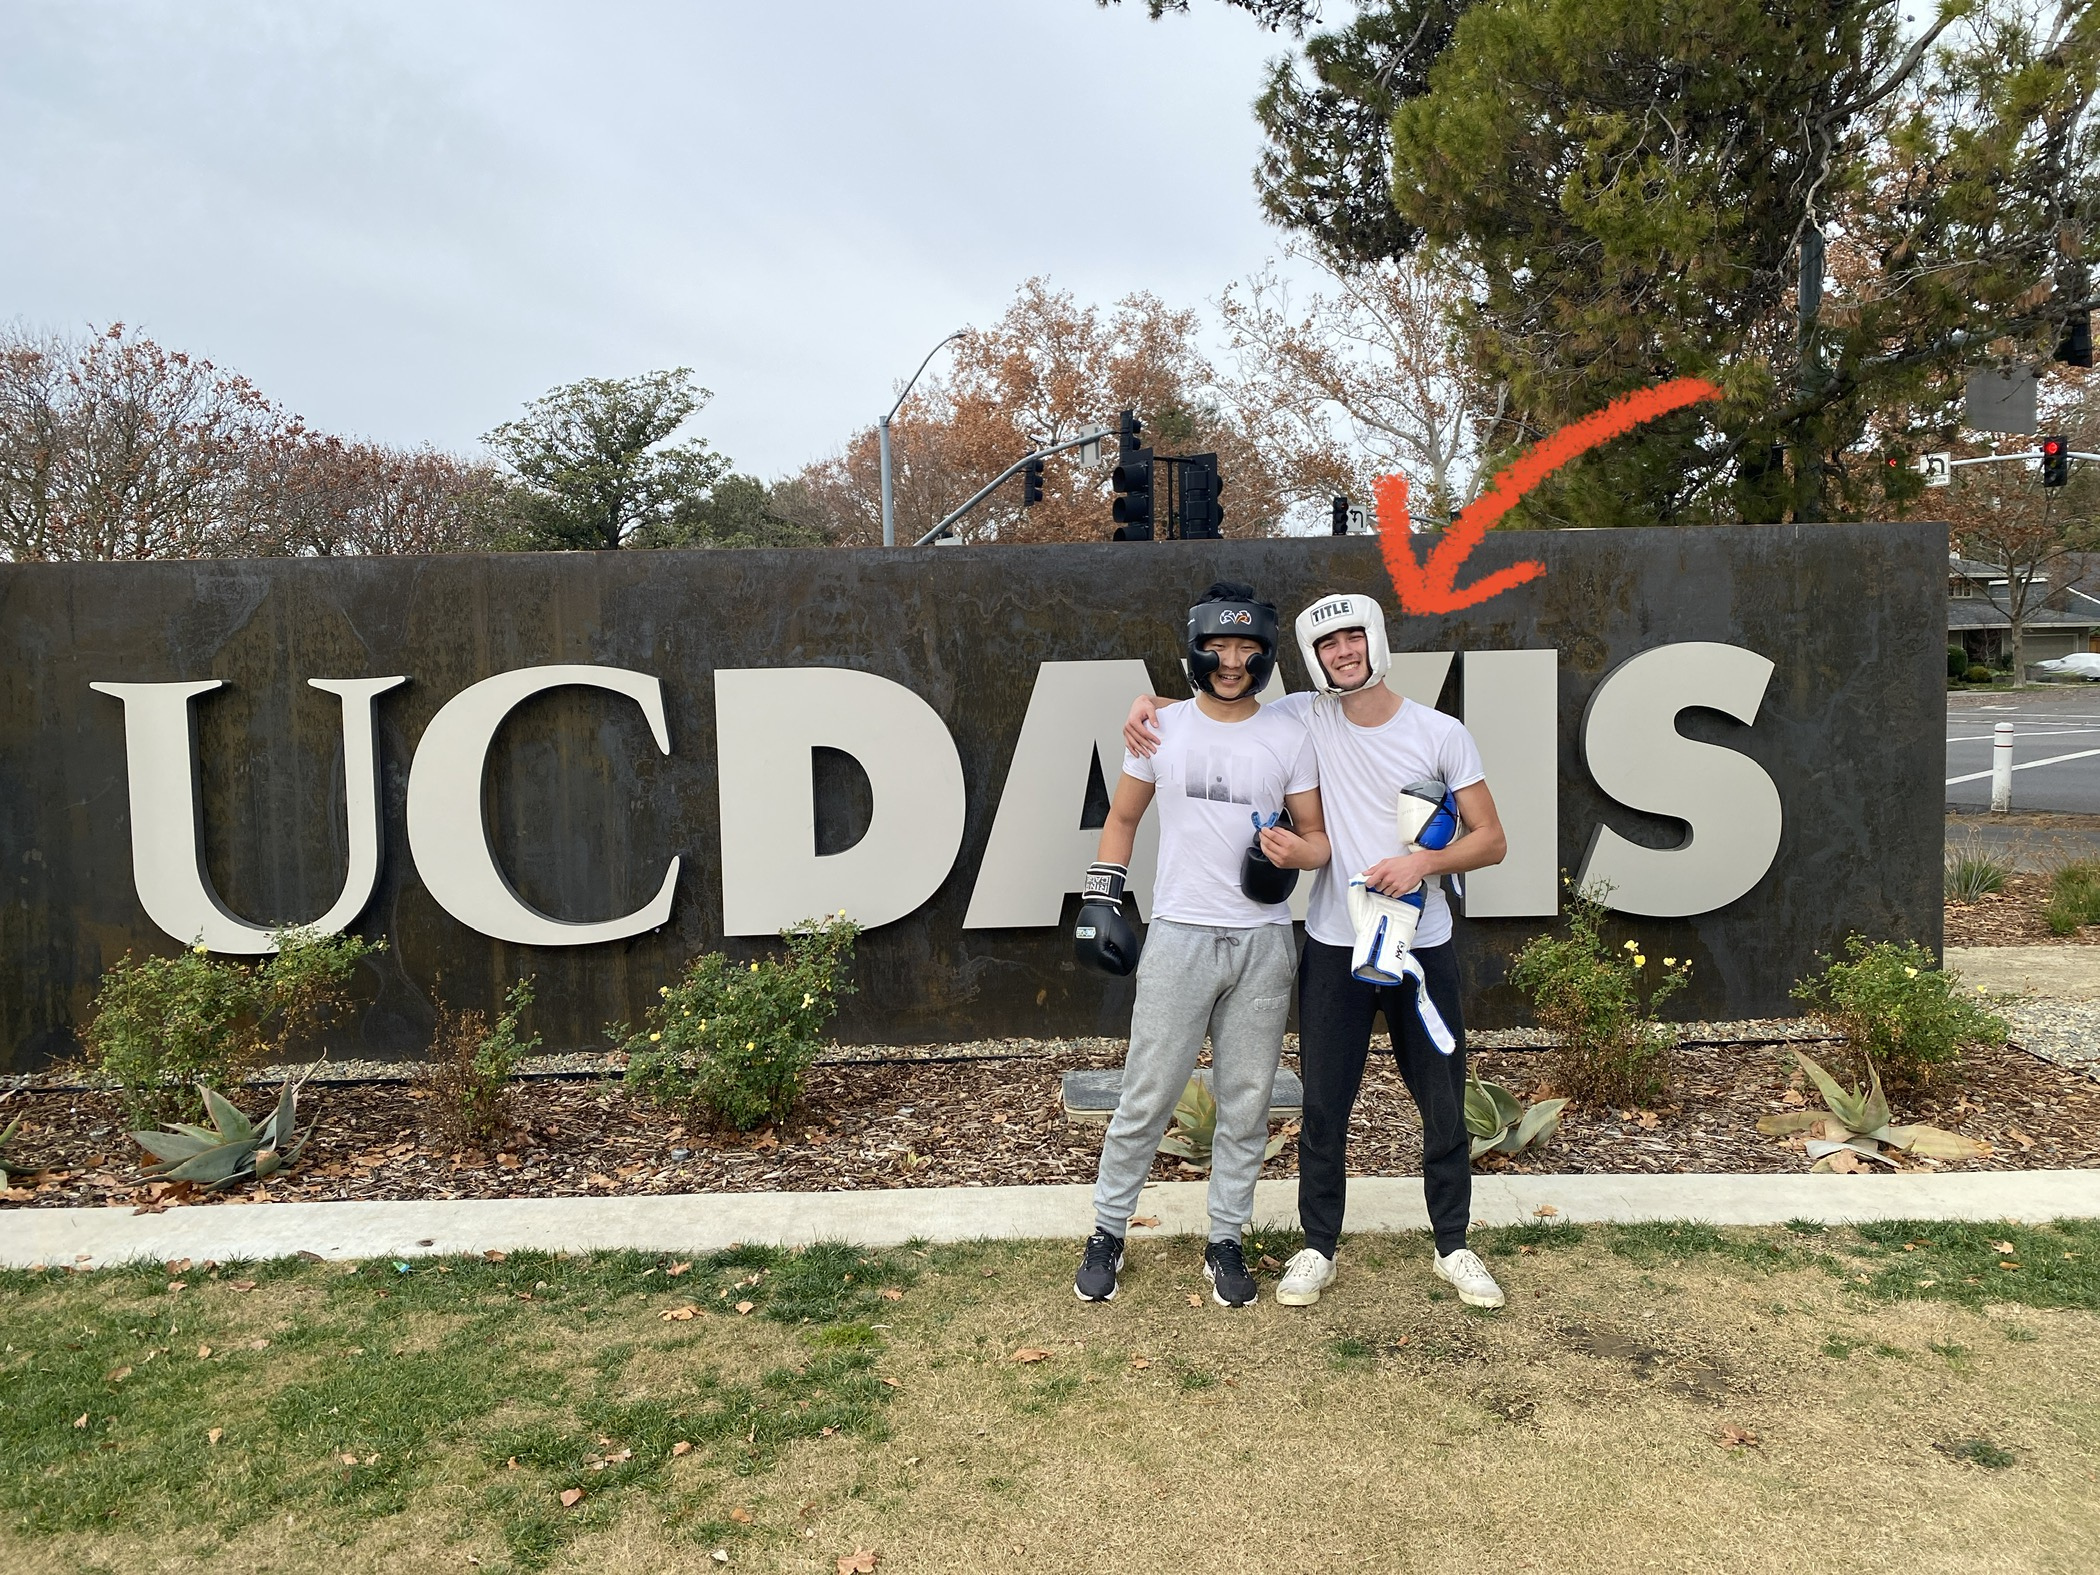

## Overview of Project:
The primary aim of this project is to create a robust and precise method for programmatically identifying and quantifying the head damage sustained by a boxer. To achieve this, a device (Raspberry Pi with an accelerometer) is attached to a boxer's headgear, and Python code is employed for data collection, storage, cleaning, and analysis. This analysis extends beyond just data visualization; it involves the development of a custom-built machine learning model for the detection of head hits amidst the chaotic head movement. This comprehensive model incorporates parameter optimization and employs rigorous evaluation metrics. This project is more than just a line on my resume; it's my successful effort to make boxing a safer and more accessible sport.





# Boxing Hit Detection Project

Required Packages

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal
import numpy as np
import mpld3
import time
# mpld3.enable_notebook()

Boxing sparing data was collected and stored (see other project files for data collection script).

**x,y,z**: Instantanious acceleration data along three axis, recorded in m/s^2.\
**time**: Time in seconds since epoch. This column is discarded.\
**label**: These are manually labeled hits to the head. 0 = no hit, 1 = hit.\
**Total**: sum of the absolute values of x,y, and z. This is a good measure for overall change in head movement

It's important to note that acceleration data is being collected at a rate of XX Hz. A hit to the head is not an instantanious event. It stretches out over 10-100 accelerometer readings. This observation is fundamental to the design of my project. The relationship between accelerometer readings is arguably more important than the readings themselves.

Since hits are not contained with a single row, regular classification models do not work. This neccessitated that I create a novel solution for identifying hits, and scoring this new model based on whether or not programatically identified hits are "close enough" to the label.

In [2]:
#Importing Boxing Data
file = "boxing_data_labeled2.csv"
df1 = pd.read_csv(file)
df1

#This data is collected from a device that was attatched to my head. X, y, and z are instantanious measures of acceleration in each dimension.
#Time is measured is a measure of seconds since some unkown time. We will not use this column.
#Label represents labeled hits to the head. 0 = no hit, 1 = hit to the head. I went throught the data and manually marked each hit.



,x,y,z,time,label
0,6.894844,-6.473492,-13.368336,1675381109,0
1,14.402563,-3.370812,-7.890766,1675381109,0
2,10.648703,-2.681328,-6.626711,1675381109,0
3,10.112438,-2.374891,-6.167055,1675381109,0
4,9.882609,-2.106758,-5.822312,1675381109,0
...,...,...,...,...,...
49993,-0.191523,-0.804398,-9.499562,1675381235,0
49994,-0.114914,-0.766094,-9.499562,1675381235,0
49995,-0.076609,-0.881008,-9.461258,1675381235,0
49996,-0.114914,-0.881008,-9.729391,1675381235,0


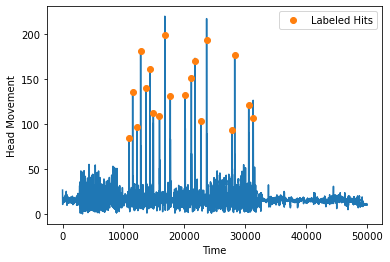

In [3]:
# Data Cleaning/Prep
df1['total'] = abs(df1['x']) + abs(df1['y']) + abs(df1['z']) # Creating an aggregate acceleration measure

plt.plot(df1['total'])
plt.plot(df1[df1['label'] == 1]['total'], 'o', label='Labeled Hits')
plt.xlabel("Time")
plt.ylabel("Head Movement")
plt.legend()
plt.show()

#Here I am splitting the dataset into training and testing splits

# Split dataset
n = len(df1)
split_percentage = 0.35

# Calculate the index to split at
split_index = int(n * split_percentage)

# Create training and test splits
training_split = df1[:split_index]
test_split = df1[split_index:]

Although the hits look like clean spikes in the graph, zooming in reveals that each 'peak' is made up of many jagged peaks of different heights. Still, hits are "spikier" than normal head movement, and as such a smothing function like a rolling mean highlights the difference between "gentle" and "sudden" changes in head acceleration. Below is the rolling mean of "total" (orange) overalyed over "total" (blue). Instances of "total" outpacing its rolling mean shows up as blue tips on the graph.

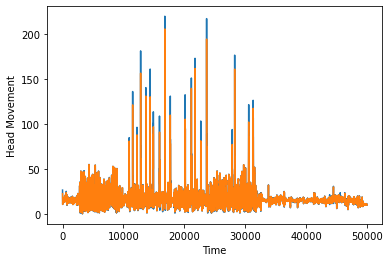

In [4]:
df = df1.copy()


meanval = 4
distance = 7

df['{}mean'.format(meanval)] = df['total'].rolling(window = meanval, center = True).mean() #creates a rolling mean of 'total'
df['hit'] = np.where((df['total'] - df['{}mean'.format(meanval)]) > distance, 1, 0) #classifies observations as 'hits' if the distance between 'total' and the rolling average is sufficient

plt.plot(df['total'])
plt.plot(df['4mean'])
plt.xlabel("Time")
plt.ylabel("Head Movement")
plt.show()


The first step in identifying hits is to mark points where the difference between "total" and the rolling mean is greater than some arbitrary threshold. Although there are far too many positive classifications for each hit, the classifications follow the hits very nicely, and no headmovement is mistakenly classified as a hit. Remember that this algorithm for classifying hits used here takes in arbitrary parameters (meanval, distance). These will be optimized later

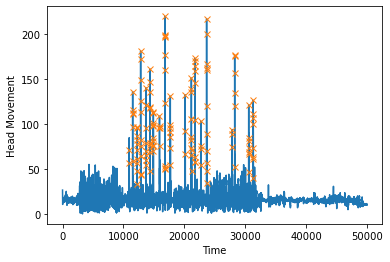

In [5]:
df = df1.copy()

meanval = 4
distance = 7

df['{}mean'.format(meanval)] = df['total'].rolling(window = meanval, center = True).mean() #creates a rolling mean of 'total'
df['hit'] = np.where((df['total'] - df['{}mean'.format(meanval)]) > distance, 1, 0) #classifies observations as 'hits' if the distance between 'total' and the rolling average is sufficient

plt.plot(df['total'])
plt.plot(df['total'][df['hit'] == 1], 'x')
plt.xlabel("Time")
plt.ylabel("Head Movement")
plt.show()

Here I go through each classified hit, scan for nearby classified hits, and erease hit classifications that are not associated with the greatest "total" for its region. This is to say that hit classifications are kept only if they are the "highest" in their local region (+/- 70 rows)

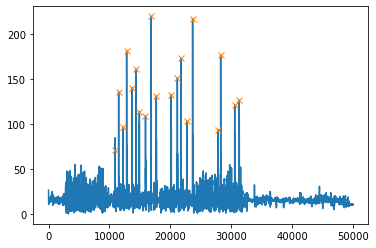

In [6]:
hit_indices = np.where(df['hit'] == 1)[0] #Algorithm for getting rid of extra "hit" classifications
for i in hit_indices:
    window_start = max(0, i - 70)
    window_end = min((len(df)-1), i + 70)
    window = df.iloc[window_start:window_end]
    max_hit = window.loc[window['hit'] == 1, 'total'].max()
    if df.iat[i, 5] != max_hit:
        df.iat[i, 7] = 0
        
plt.plot(df['total'])
plt.plot(df['total'][df['hit'] == 1], 'x')

These processes make up a model for taking in boxing data, and outputting hit classifications. Now, a method for programatically finding the best model parameters is created. This is done by iterrating through a range of possible paramaters, and creating a method for evaluating the accuracy of the model's hit classifications.

In [7]:
def algorithm_tuning(df1):
    
    #creating set of possible values for model parameters
    meanval_range = np.arange(start=3, stop=10, step=1, dtype = int)
    distance_range = np.arange(start=1, stop=20, step=1, dtype = int)
    
    score_and_parameters = [] #place holder array for model tuning results

    for meanval in meanval_range:
        for distance in distance_range:
            df = df1.copy(deep = True) #creates a new dataframe to preserve the original training split
            
            #running algorithm with each combination of parameters
            df['{}mean'.format(meanval)] = df['total'].rolling(window = meanval, center = True).mean() #creates a rolling mean of 'total'
            df['hit'] = np.where((df['total'] - df['{}mean'.format(meanval)]) > distance, 1, 0) #classifies observations as 'hits' if the distance between 'total' and the rolling average is sufficient

            hit_indices = np.where(df['hit'] == 1)[0]
            for i in hit_indices:
                window_start = max(0, i - 70)
                window_end = min((len(df)-1), i + 70)
                window = df.iloc[window_start:window_end]
                max_hit = window.loc[window['hit'] == 1, 'total'].max()
                if df.iat[i, 5] != max_hit:
                    df.iat[i, 7] = 0
            
             #evaluating model accuracy                                   

            df['eval'] = np.where(df['hit'] == 1, np.where(df['label'].rolling(50, center = True).sum() == 0, "False Positive", 'True Positive'), None) #creating 'eval' metric, which represents the accuracy of each classification relative to the training set
            df['eval'] = np.where(df['label'] == 1, np.where(df['hit'].rolling(50, center = True).sum() == 0, 'False Negative', df['eval']), df['eval'])
            df['eval'].fillna(value = 'True Negative', inplace = True)                    

            truepositive = (df['eval'] == "True Positive").sum() #assigning classifications to variables
            falsepositive = (df['eval'] == "False Positive").sum()
            truenegative = (df['eval'] == "True Negative").sum()
            falsenegative = (df['eval'] == "False Negative").sum()

            if (truepositive + falsepositive) == 0:
                continue
            if (truepositive + falsenegative) == 0:
                continue

            precision = truepositive/(truepositive + falsepositive) #precision measure that is penalized by over classification
            recall = truepositive/(truepositive + falsenegative) #accuracy is a measure that is penalized by under classification

            #0.5 is chosen to put an emphasis on higher precision, because
            #mistakenly classifying head movement as hits is worse than classifying hits as head movement

            beta = 0.5 
            f_beta_score = (1+beta**2)*((precision*recall)/(beta**2*precision+recall)) #represents a weighted average of precision and recall. 0.5 is chosen to put a heavier emphasis on higher precision, because mistakenly classifying head movement as hits is worse than classifying hits as head movement

            score_and_parameters += [[f_beta_score, precision, recall, truepositive, falsepositive, truenegative, falsenegative, meanval, distance]]
               
    score_and_parameters = np.array(score_and_parameters)            
    score_and_parameters = score_and_parameters[score_and_parameters[:,0].argsort()][::-1] #orders accuracy array by highest f_beta_score, then by shortest cooldown, allowing identification of the paramaters for the highest accuracy model with the shortest "window" needed to classify a hit correctly
    score_and_parameters = score_and_parameters[score_and_parameters[:,0].argsort(kind = 'mergesort')][::-1]
    return score_and_parameters

def hit_detection_algorithm(df1, meanval, distance):
    df = df1.copy(deep = True) #creates a new dataframe to preserve the original training split
            
    #running algorithm with each combination of parameters
    df['{}mean'.format(meanval)] = df['total'].rolling(window = meanval, center = True).mean() #creates a rolling mean of 'total'
    df['hit'] = np.where((df['total'] - df['{}mean'.format(meanval)]) > distance, 1, 0) #classifies observations as 'hits' if the distance between 'total' and the rolling average is sufficient
    hit_indices = np.where(df['hit'] == 1)[0]
    for i in hit_indices:
        window_start = max(0, i - 70)
        window_end = min((len(df)-1), i + 70)
        window = df.iloc[window_start:window_end]
        max_hit = window.loc[window['hit'] == 1, 'total'].max()
        if df.iat[i, 5] != max_hit:
            df.iat[i, 7] = 0
    return df

def model_evaluation(df1):
    df = df1.copy(deep = True) #creates a new dataframe to preserve the original training split
    df['eval'] = np.where(df['hit'] == 1, np.where(df['label'].rolling(50, center = True).sum() == 0, "False Positive", 'True Positive'), None) #creating 'eval' metric, which represents the accuracy of each classification relative to the training set
    df['eval'] = np.where(df['label'] == 1, np.where(df['hit'].rolling(50, center = True).sum() == 0, 'False Negative', df['eval']), df['eval'])
    df['eval'].fillna(value = 'True Negative', inplace = True)                    

    truepositive = (df['eval'] == "True Positive").sum() #assigning classifications to variables
    falsepositive = (df['eval'] == "False Positive").sum()
    truenegative = (df['eval'] == "True Negative").sum()
    falsenegative = (df['eval'] == "False Negative").sum()

    precision = truepositive/(truepositive + falsepositive) #precision measure that is penalized by over classification
    recall = truepositive/(truepositive + falsenegative) #accuracy is a measure that is penalized by under classification

    #0.5 is chosen to put a heavier emphasis on higher precision, because
    #mistakenly classifying head movement as hits is worse than classifying hits as head movement

    beta = 0.5 
    f_beta_score = (1+beta**2)*((precision*recall)/(beta**2*precision+recall)) #represents a weighted average of precision and recall. 0.5 is chosen to put a heavier emphasis on higher precision, because mistakenly classifying head movement as hits is worse than classifying hits as head movement
    
    accuracy_array = np.array([f_beta_score, precision, recall, truepositive, falsepositive, truenegative, falsenegative])
    return accuracy_array



On the test data: f_score = 1.0, True Positives = 10.0, False Positives = 0.0, False Negatives = 0.0


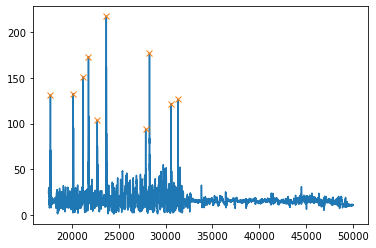

In [11]:
params = algorithm_tuning(training_split)

f_beta_score = params[0][0]
meanval = int(params[0][7])
distance = int(params[0][8])

# print(f_beta_score)
# print(meanval)
# print(distance)

hits_identified = hit_detection_algorithm(test_split, meanval, distance)

plt.plot(hits_identified['total'])
plt.plot(hits_identified['total'][hits_identified['hit'] == 1], 'x')  
# plt.plot(hits_identified['total'][hits_identified['label'] == 1], 'o')  

results = model_evaluation(hits_identified)

f_beta_score = results[0]
precision = results[1]
recall = results[2]
truepositive = results[3]
falsepositive = results[4]
truenegative = results[5]
falsenegative = results[6]

print('On the test data: f_score = {}, True Positives = {}, False Positives = {}, False Negatives = {}'.format(f_beta_score, truepositive, falsepositive, falsenegative))



Final Thoughts and Applications

Citations and Notes